# Sketch to Image processing using Pix2Pix architecture

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import time
from glob import glob

import numpy as np
import pydot
import graphviz

from matplotlib import pyplot as plt
from IPython import display

from PIL import Image
from pathlib import Path, PurePath

In [2]:
tf.__version__

'2.0.0'

## Load the dataset

#### Define constant variables

In [3]:
train_sketch_src = Path("/home/jakub/Desktop/semestr9/GSN/sketch-to-image/notebooks/data/dataset/sketch_img")
train_org_img_src = Path("/home/jakub/Desktop/semestr9/GSN/sketch-to-image/notebooks/data/dataset/original_img")
test_sketch_src = Path("/home/jakub/Desktop/semestr9/GSN/sketch-to-image/notebooks/data/dataset_test/sketch_img")
test_org_img_src = Path("/home/jakub/Desktop/semestr9/GSN/sketch-to-image/notebooks/data/dataset_test/original_img")

files_structure = "/**/**/*.png"

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE

#### Define helper functions

In [5]:
def resize_imgs(img, sketch, height, width):
    img = tf.image.resize(img, [height, width])
    sketch = tf.image.resize(sketch, [height, width])

    return img, sketch

In [6]:
def normalize(img, sketch):
    img = (img / 127.5) - 1
    sketch = (sketch / 127.5) - 1

    return img, sketch

In [7]:
def random_crop(img, sketch):
    stacked_image = tf.stack([img, sketch], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
@tf.function()
def random_jitter(img, sketch):
    # resizing to 286 x 286 x 3
    img, sketch = resize_imgs(img, sketch, 286, 286)

    # randomly cropping to 256 x 256 x 3
    img, sketch = random_crop(img, sketch)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        img = tf.image.flip_left_right(img)
        sketch = tf.image.flip_left_right(sketch)

    return img, sketch

In [9]:
def load_imgs(img_path, sketch_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(img_path)
    sketch = tf.io.read_file(sketch_path)
    
    img = tf.image.decode_png(img, channels=3)
    sketch = tf.image.decode_png(sketch, channels=3)
    
    img = tf.cast(img, tf.float32)
    sketch = tf.cast(sketch, tf.float32)
    
    return img, sketch

#### Load train / test set

In [10]:
def load_image_train(image_path, sketch_path):
    img, sketch = load_imgs(image_path, sketch_path)
    img, sketch = random_jitter(img, sketch)
    img, sketch = normalize(img, sketch)

    return img, sketch

In [11]:
def load_image_test(image_path, sketch_path):
    img, sketch = load_imgs(image_path, sketch_path)
    img, sketch = resize_imgs(img, sketch, IMG_HEIGHT, IMG_WIDTH)
    img, sketch = normalize(img, sketch)

    return img, sketch

#### Example image

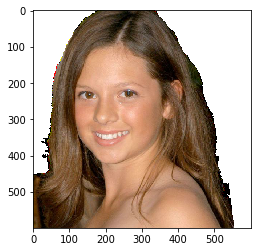

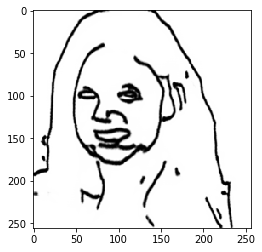

In [12]:
exaple_img_path = "/1803151818/matting_00000000/1803151818-00000003.png"
inp, re = load_imgs(str(train_org_img_src) + exaple_img_path, str(train_sketch_src) + exaple_img_path)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

#### Read all data

In [13]:
train_dataset_sketch = tf.data.Dataset.list_files(str(train_sketch_src) + files_structure)
train_dataset = train_dataset_sketch.map(lambda t: (tf.strings.regex_replace(t, "sketch_img", "original_img"), t))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset_sketch = tf.data.Dataset.list_files(str(test_sketch_src) + files_structure)
test_dataset = test_dataset_sketch.map(lambda t: (tf.strings.regex_replace(t, "sketch_img", "original_img"), t))
test_dataset = test_dataset.map(load_image_test)

test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator

#### GAN helper functions

In [15]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

#### Generator

In [17]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

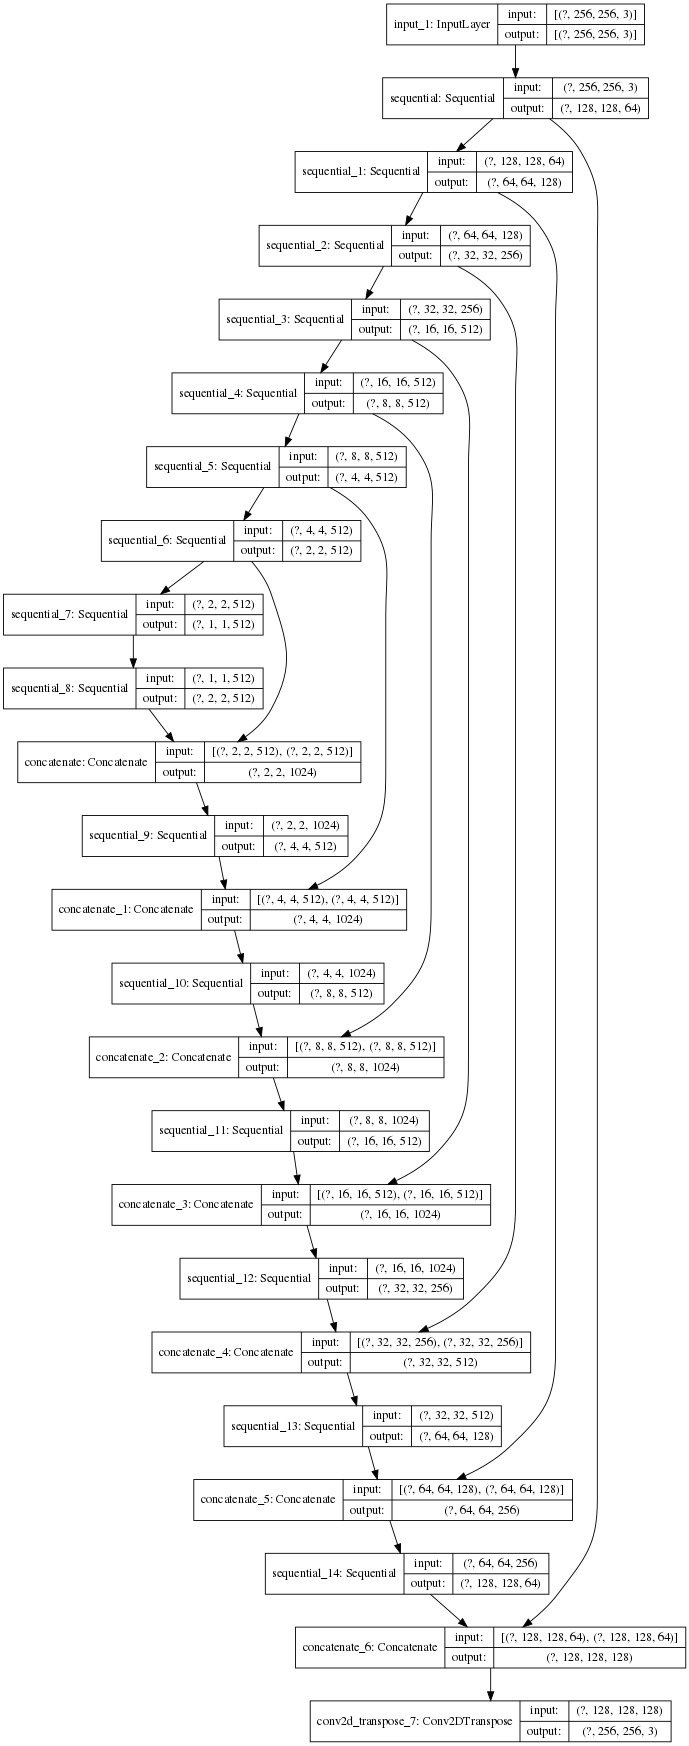

In [18]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

#### Generator loss

In [19]:
LAMBDA = 100

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Build the Discriminator

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

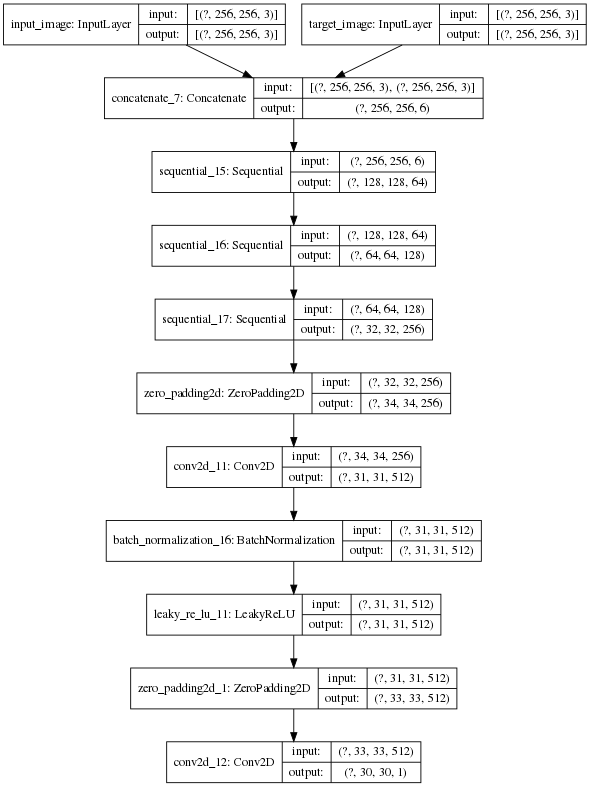

In [22]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

#### Discriminator loss

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

#### Optimizers and checkopint

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Generate images

In [27]:
def generate_images(model, img, sketch):
    prediction = model(sketch, training=True)
    plt.figure(figsize=(15,15))

    display_list = [sketch[0], img[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

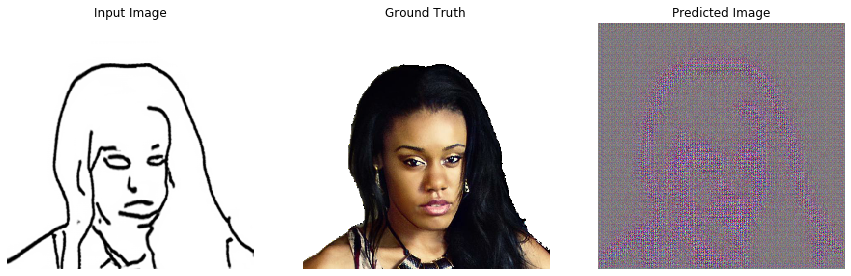

In [28]:
for img, sketch in test_dataset.take(1):    
    generate_images(generator, img, sketch)

## Train GAN

In [29]:
EPOCHS = 150

In [30]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [31]:
@tf.function
def train_step(img, sketch, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(sketch, training=True)

        disc_real_output = discriminator([sketch, img], training=True)
        disc_generated_output = discriminator([sketch, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, img)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [32]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

#         display.clear_output(wait=True)

        for img, sketch in test_ds.take(1):
            generate_images(generator, img, sketch)
        print("Epoch: ", epoch)

        # Train
        for n, (img, sketch) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 10 == 0:
                print()
                generate_images(generator, img, sketch)
            train_step(img, sketch, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

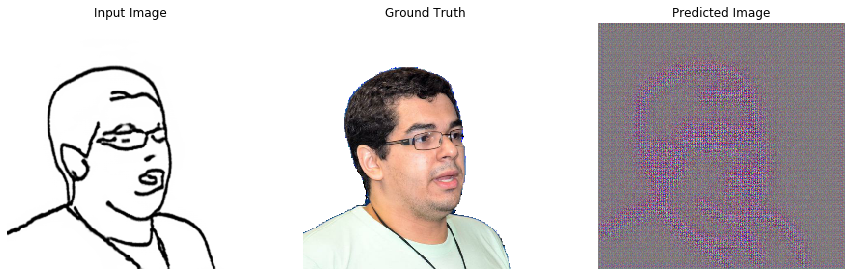

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)